In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## Load data

In [2]:
from helper import load_data, normalize_data

data = load_data()
(N, d) = data.shape
print("Number of data points: ", N)
print("Dimension of each data point: ", d)

Number of data points:  272
Dimension of each data point:  2


### Initialize your cluster centers

In [3]:

def initialize_clusters(data, k):
    """randomly initialize the k cluster centers (the means). Make sure you choose k clusters from the data itself,
             or ensure otherwise that your initializations have the same scale as the data

    Args:
        data: shape = (N, d). original data.
        k: integer number. predefined number of clusters for the k-means algorithm.
    Returns:
        numpy array with shape (k, d) which corresponds to the k initial clusters.
    """
    ####################################
    ### ___ Enter your code here ___ ###
    ####################################

    return data[np.random.choice(N, k)]

In [4]:
initialize_clusters(data,5)

array([[ 3.5  , 66.   ],
       [ 4.5  , 81.   ],
       [ 1.867, 47.   ],
       [ 4.633, 82.   ],
       [ 1.833, 46.   ]])

### Update k-means parameters

#### Build distance matrix
Build a distance matrix, collecting the distances of the original dataset to the means of the clusters.

NOTE: once you finish your `build_distance_matrix`, please copy the function to the `helper.py` function. Otherwise, the `kmeans` function will not work.

In [23]:
def build_distance_matrix(data, mu):
    """builds a distance matrix.

    Args:
        data: numpy array of shape = (N, d). original data.
        mu:   numpy array of shape = (k, d). Each row corresponds to a cluster center.
    Returns:
        numpy array of shape (N, k):
            squared distances matrix,
            the value row i column j corresponds to the squared distance of datapoint i with cluster center j.
    """
    ####################################
    ### ___ Enter your code here ___ ###
    ####################################
    N, d = data.shape
    k, _ = mu.shape
    distance_matrix = np.zeros((N, k))
    for i in range(N):
        for j in range(k):
            distance_matrix[i,j] = np.linalg.norm(data[i]-mu[j])**2
    return distance_matrix
    

#### Update k-means parameters

In [26]:
def update_kmeans_parameters(data, mu_old):
    """compute one step of the kmeans algorithm: using mu_old, find to which cluster each datapoint belongs to,
            then update the parameter cluster centers.

    Args:
        data:   numpy array of shape = (N, d). original data.
        mu_old: numpy array of shape = (k, d). Each row corresponds to a cluster center.
    Returns:
        losses: shape (N, ), contains the (old) squared distances of each data point to its (old) cluster mean (computed from mu_old).
        assignments: vector of shape (N, ) which contains the cluster associated to each data point.
        mu: updated vector mu of shape (k, d) where each row corresponds to the new cluster center.
    """
    ####################################
    ### ___ Enter your code here ___ ###
    ####################################
    d = data.shape[1]
    k = mu_old.shape[0]
    distance_matrix = build_distance_matrix(data, mu_old)
    print(distance_matrix.shape)
    losses = np.min(distance_matrix, axis=1)
    print(losses.shape)
    assignments = np.argmin(distance_matrix, axis=1)
    print(assignments.shape)
    
    # update mu
    mu = np.zeros((k, d))
    for j in range(k):
        rows = np.where(assignments == j)[0]
        mu[j, :] = np.mean(data[rows, :], axis=0)
    return losses, assignments, mu

#### Play with k-means

(272, 2)
(272,)
(272,)
The current iteration of k-means is: 0,                    the average loss is 65.12866850367648.


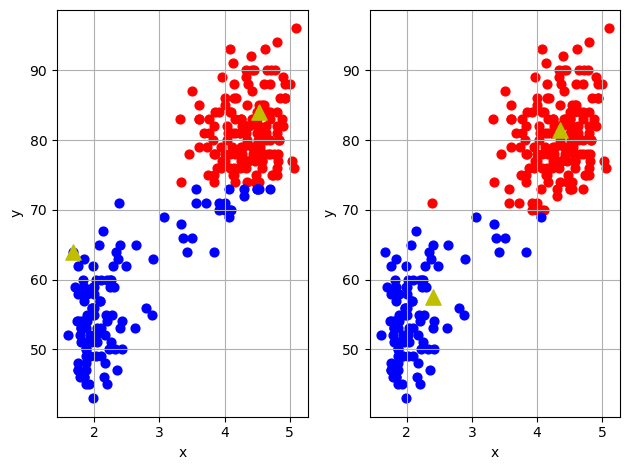

(272, 2)
(272,)
(272,)
The current iteration of k-means is: 1,                    the average loss is 36.001532345934706.


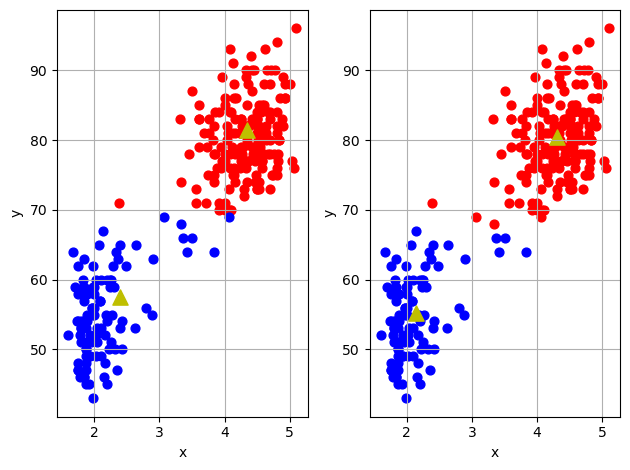

(272, 2)
(272,)
(272,)
The current iteration of k-means is: 2,                    the average loss is 32.81512971023837.


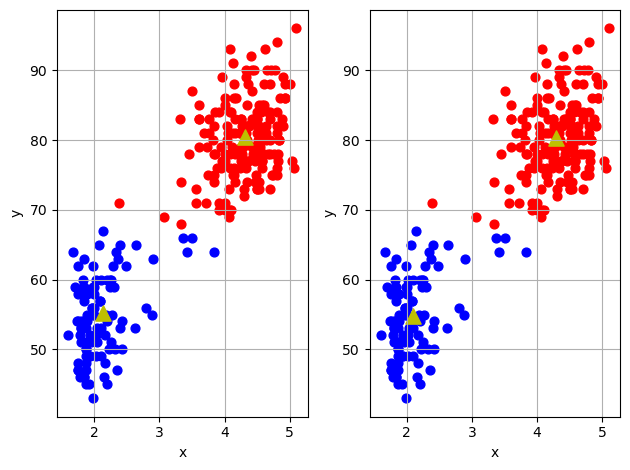

(272, 2)
(272,)
(272,)
The current iteration of k-means is: 3,                    the average loss is 32.72709088583533.


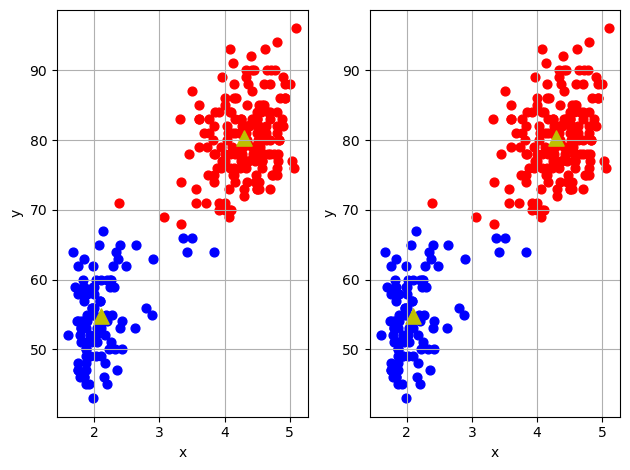

(272, 2)
(272,)
(272,)
The current iteration of k-means is: 4,                    the average loss is 32.72709088583533.


In [27]:
from helper import build_dir
from plots import plot


def kmeans(data, k, max_iters, threshold, verbose=True):
    """run the k-means algorithm."""
    output_figure = "kmeans_figures/"
    # initialize the cluster.
    mu_old = initialize_clusters(data, k)
    # init some empty lists to store the result.
    loss_list = []

    # start the kmeans algorithm.
    for iteration in range(max_iters):
        # update z and mu
        losses, assignments, mu = update_kmeans_parameters(data, mu_old)
        # calculate the average loss over all points
        average_loss = np.mean(losses)
        loss_list.append(average_loss)
        if verbose:
            print(
                "The current iteration of k-means is: {i}, \
                   the average loss is {l}.".format(
                    i=iteration, l=average_loss
                )
            )
        # check convergence
        if iteration > 0 and np.abs(loss_list[-1] - loss_list[-2]) < threshold:
            break
        # output plot
        if verbose:
            plot(data, mu, mu_old, output_figure + "kmean_iter{i}".format(i=iteration))
        # update k-means information.
        mu_old = mu
    return average_loss


# define parameters
k = 2
max_iters = 10
threshold = 1e-5
output_figure = "kmeans_figures/"

# build figure dir
build_dir(output_figure)

# run kmeans algorithm
average_loss = kmeans(data, k, max_iters, threshold)

### Plotting the loss as a function of number of clusters

In [ ]:
# don't worry about empty slice warnings
import warnings

warnings.filterwarnings("ignore")

losses = []
ks = np.arange(2, 17)
for k in ks:
    average_loss = kmeans(data, k, max_iters, threshold, verbose=False)
    losses += [average_loss]
plt.figure(figsize=(5, 3))
plt.xlabel("number of clusters k", fontsize=13)
plt.ylabel("average loss", fontsize=13)
plt.plot(ks, losses)
plt.show()

## Using k-means for image compresson

#### load image

In [20]:
from helper import load_image

image_path = "mandrill.png"
original_image = load_image(image_path)
print(
    "Original image: the shape of image={s}, the data type={dt}.".format(
        s=original_image.shape, dt=original_image.dtype
    )
)

Original image: the shape of image=(480, 480, 3), the data type=float32.


#### preprocess image

In [21]:
def preprocess_image(original_image):
    """preprocess the image.
    vectorize the three matrices (each matrix corresponds to a RGB color channel). **don't normalize!**

    Args:
        original_image: numpy array of shape (480, 480, 3)
    Returns:
        processed_image: numpy array of shape (480*480, 3)
    """
    ####################################
    ### ___ Enter your code here ___ ###
    ####################################
    processed_image = original_image.reshape(-1, 3)
    # equiv to original_image.reshape(original_image.shape[0] * original_image.shape[1], 3)
    print(processed_image.shape)
    return processed_image


processed_image = preprocess_image(original_image)

(230400, 3)


(230400, 5)
(230400,)
(230400,)
The average loss is 0.07375720174153974.


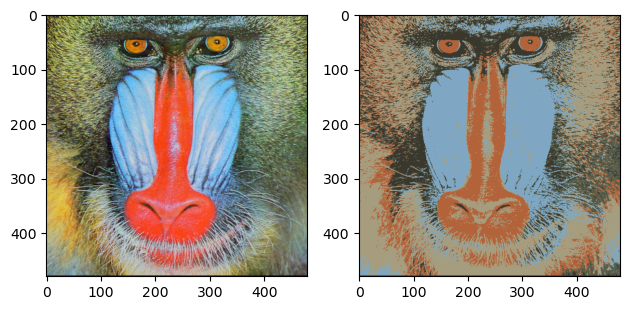

In [22]:
from plots import plot_image_compression


def kmean_compression(original_image, processed_image, k, max_iters, threshold):
    """using k-means for image compression.
    Args:
        original_image: numpy array of shape (480, 480, 3).
        processed_image: numpy array of shape (480*480, 3).
        k: scalar. Number of clusters.
        max_iters: integer. Max number of iterations for the kmeans algorithm.
        threshold: scalar. Stop the kmeans algorithm if the loss decrease between two iterations
                        is lower than the threshold.
    """

    ####################################
    ### ___ Enter your code here ___ ###
    ####################################
    mu = initialize_clusters(processed_image, k)
    losses, assignments, mu = update_kmeans_parameters(processed_image, mu)
    average_loss = np.mean(losses)
    print("The average loss is {l}.".format(l=average_loss))    
    
    # plot histogram
    plot_image_compression(original_image, processed_image, assignments, mu, k)


# define parameters
k = 5
max_iter = 100
threshold = 1e-7

# use kmeans to compress image
kmean_compression(original_image, processed_image, k, max_iter, threshold)